In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basetable_train = pd.read_csv('../../Data/Gold/basetable_train.csv')
basetable_test = pd.read_csv('../../Data/Gold/basetable_test.csv')

In [3]:
basetable_train.columns

Index(['niveau', 'is_thuisploeg', 'kwart', 'is_schepper_bank',
       'is_kopper_bank', 'schepper_pos_rechts', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal',
       'score_verschil_voor', 'wedstrijd_corner_nr',
       'ploeg_wedstrijd_corner_nr', 'positie_verticaal_voor',
       'positie_horizontaal', 'ploeg_scoreperc', 'goal_lag_ploeg',
       'goal_lag_wedstrijd', 'klassement', 'klassement_veschil',
       'is_degradatieplaats', 'is_promotieplaats', 'algemene_ervaring'],
      dtype='object')

### Scaling and Onehotencoding

In [4]:
# Onehot encoding
cat_cols = ["positie_horizontaal", "niveau"]

# Combine train and test to ensure consistent columns
combined = pd.concat([basetable_train, basetable_test], keys=["train", "test"])

# One-hot encode only the categorical columns
combined_encoded = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into train and test
train_df_encoded = combined_encoded.xs("train")
test_df_encoded = combined_encoded.xs("test")



In [5]:
# StandardScaler numerical columns
from sklearn.preprocessing import StandardScaler

# 1. Select numerical columns (exclude dummies)
numerical_cols = ["algemene_ervaring",
                   "score_verschil_voor", "wedstrijd_corner_nr", 
                   "ploeg_wedstrijd_corner_nr", 'klassement', 'klassement_veschil', 'ploeg_scoreperc']

# 2. Fit scaler on train only
scaler = StandardScaler()
scaler.fit(train_df_encoded[numerical_cols])

# 3. Transform train and test
train_df_encoded[numerical_cols] = scaler.transform(train_df_encoded[numerical_cols])
test_df_encoded[numerical_cols] = scaler.transform(test_df_encoded[numerical_cols])


C:\Users\cosyn\AppData\Local\Temp\ipykernel_5044\188906273.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_encoded[numerical_cols] = scaler.transform(train_df_encoded[numerical_cols])
C:\Users\cosyn\AppData\Local\Temp\ipykernel_5044\188906273.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_encoded[numerical_cols] = scaler.transform(test_df_encoded[numerical_cols])


### features and target

In [6]:
X_train = train_df_encoded.drop("goal", axis=1)
y_train = train_df_encoded["goal"]

X_test = test_df_encoded.drop("goal", axis=1)
y_test = test_df_encoded["goal"]

In [7]:
X_train.columns

Index(['is_thuisploeg', 'kwart', 'is_schepper_bank', 'is_kopper_bank',
       'schepper_pos_rechts', 'kop_verplaatsen_achter', 'kop_veel_verplaatsen',
       'kop_hor_verplaatsen', 'score_verschil_voor', 'wedstrijd_corner_nr',
       'ploeg_wedstrijd_corner_nr', 'positie_verticaal_voor',
       'ploeg_scoreperc', 'goal_lag_ploeg', 'goal_lag_wedstrijd', 'klassement',
       'klassement_veschil', 'is_degradatieplaats', 'is_promotieplaats',
       'algemene_ervaring', 'positie_horizontaal_midden',
       'positie_horizontaal_rechts', 'niveau_kern_laag', 'niveau_nationaal'],
      dtype='object')

### Baseline logistic model

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [9]:

# 2. Instantiate baseline logistic regression (no tuning)
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# 3. Fit model
baseline_model.fit(X_train, y_train)

# 4. Predict
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:,1]

In [10]:
### interpretaties
print("Coefficients:", baseline_model.coef_)
print("Intercept:", baseline_model.intercept_)

Coefficients: [[-0.48932177 -0.25988982 -0.51678468  0.16475277 -0.28659076 -3.10831637
  -2.40517847 -1.95430633  0.28678479  0.09607789  0.19121731  0.27739623
  -0.20838259  0.97489447 -0.03809711  0.03707975 -0.06268341 -0.78999829
  -0.49199539  0.34578774 -0.68510102 -0.22403929  0.00992879  0.5555964 ]]
Intercept: [3.27474453]


In [11]:
X_train = X_train.astype(float)


In [12]:
import statsmodels.api as sm

# Voeg intercept toe
X_train_const = sm.add_constant(X_train)

# Fit logistische regressie
model = sm.Logit(y_train, X_train_const).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.299513
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                  482
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                           24
Date:                Wed, 28 May 2025   Pseudo R-squ.:                  0.5308
Time:                        12:03:20   Log-Likelihood:                -144.37
converged:                       True   LL-Null:                       -307.72
Covariance Type:            nonrobust   LLR p-value:                 6.778e-55
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          3.9090      1.207      3.238      0.001      

In [104]:
# Haal coëfficiënten en p-waarden op
coefs = model.params
p_values = model.pvalues

# Bereken odds ratio en procentuele verandering in odds
odds_ratios = np.exp(coefs)
percent_change = (odds_ratios - 1) * 100

# Bereken marginale effecten op kans (average marginal effects)
marginal_effects = model.get_margeff(at='mean', method='dydx')
marginal_df = marginal_effects.summary_frame()[['dy/dx']]
marginal_df.columns = ['marginal_effect_on_probability']
marginal_df['percent_point_change_in_probability'] = marginal_df['marginal_effect_on_probability'] * 100

# Combineer alle informatie
summary_df = pd.DataFrame({
    'coefficient': coefs,
    'p_value': p_values,
    'odds_ratio': odds_ratios,
    'percent_change_in_odds': percent_change
})

# Voeg marginale effecten toe aan de samenvatting
summary_df = summary_df.join(marginal_df)

# Filter voor p < 0.10, rond af op 3 decimalen en sorteer op p-waarde
summary_df_rounded = summary_df[summary_df.p_value <= 0.1].round(2).sort_values(by='p_value', ascending=True).drop(columns=['odds_ratio'])

# Toon de samengevoegde tabel
summary_df_rounded

,coefficient,p_value,percent_change_in_odds,marginal_effect_on_probability,percent_point_change_in_probability
const,3.91,0.00,4884.84,NaN,NaN
kop_verplaatsen_achter,-4.26,0.00,-98.59,-0.87,-87.26
kop_veel_verplaatsen,-2.98,0.00,-94.93,-0.61,-61.03
kop_hor_verplaatsen,-2.26,0.00,-89.61,-0.46,-46.35
goal_lag_ploeg,1.64,0.02,414.66,0.34,33.54
score_verschil_voor,0.34,0.05,40.36,0.07,6.94
positie_horizontaal_midden,-1.21,0.05,-70.21,-0.25,-24.79
is_schepper_bank,-0.82,0.06,-55.75,-0.17,-16.69
algemene_ervaring,0.35,0.07,41.84,0.07,7.15
is_thuisploeg,-0.56,0.09,-42.68,-0.11,-11.39


In [13]:
X_train_const

,const,is_thuisploeg,kwart,is_schepper_bank,is_kopper_bank,schepper_pos_rechts,kop_verplaatsen_achter,kop_veel_verplaatsen,kop_hor_verplaatsen,score_verschil_voor,...,goal_lag_wedstrijd,klassement,klassement_veschil,is_degradatieplaats,is_promotieplaats,algemene_ervaring,positie_horizontaal_midden,positie_horizontaal_rechts,niveau_kern_laag,niveau_nationaal
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.314278,...,0.608553,0.199415,0.159038,0.0,0.0,-1.657781,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.259562,...,1.000000,0.199415,0.159038,0.0,0.0,-1.657781,0.0,1.0,1.0,0.0
2,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,-0.314278,...,0.608553,0.199415,0.159038,0.0,0.0,-0.292897,0.0,1.0,1.0,0.0
3,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.707738,...,0.000000,0.199415,0.159038,0.0,0.0,-3.162732,0.0,1.0,1.0,0.0
4,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.866102,...,0.000000,0.199415,0.159038,0.0,0.0,-0.292897,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.079182,...,0.608553,-2.127469,-1.793987,0.0,1.0,-0.292897,1.0,0.0,1.0,0.0
478,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.314278,...,0.000000,-1.769487,-1.793987,0.0,1.0,-0.811246,1.0,0.0,1.0,0.0
479,1.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,-0.707738,...,1.000000,-2.127469,-1.793987,0.0,1.0,-0.292897,0.0,0.0,1.0,0.0
480,1.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,1.259562,...,0.000000,-1.769487,-1.793987,0.0,1.0,-0.811246,1.0,0.0,1.0,0.0


In [14]:
non_numeric = X_train.select_dtypes(include=['object', 'category'])
print(non_numeric.head())


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [15]:
def plot_roc_curve(y_true, y_proba, label="Model", color="blue"):
    """
    Plots ROC curve for a given set of true labels and predicted probabilities.
    
    Parameters:
    - y_true: Ground truth binary labels (1D array-like)
    - y_proba: Predicted probabilities for the positive class (1D array-like)
    - label: Label for the legend (e.g., model name)
    - color: Line color in the plot
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})", color=color)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

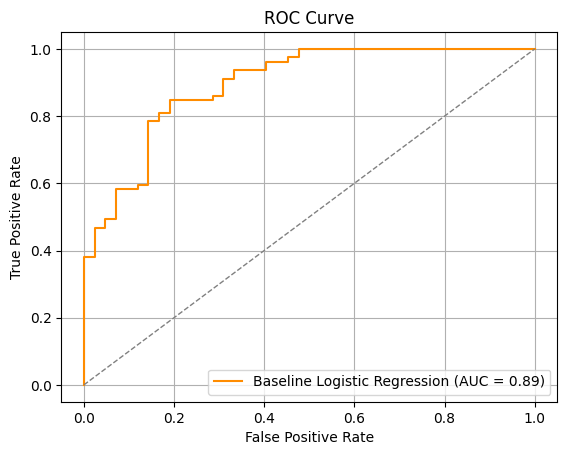

In [16]:
plot_roc_curve(y_test, y_proba_baseline, label="Baseline Logistic Regression", color="darkorange")


In [17]:
def plot_confusion_matrix(y_true, y_pred, labels=[0, 1], normalize=None, title="Confusion Matrix", cmap="Blues"):
    """
    Plots a confusion matrix.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - labels: List of class labels (default [0, 1])
    - normalize: {‘true’, ‘pred’, ‘all’}, default=None. Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population.
    - title: Plot title
    - cmap: Color map
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, values_format=".2f" if normalize else "d")
    plt.title(title)
    plt.grid(False)
    plt.show()

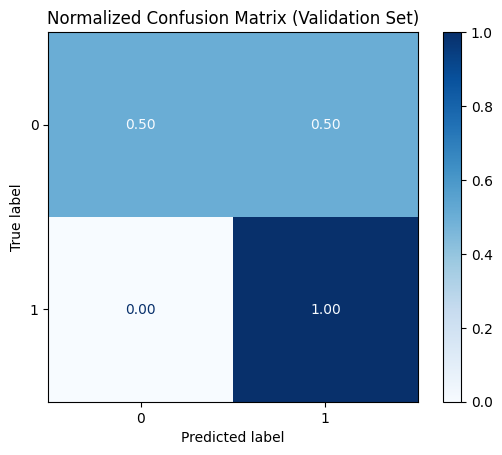

In [18]:
plot_confusion_matrix(y_test, y_pred_baseline, normalize="true", title="Normalized Confusion Matrix (Validation Set)", cmap="Blues")

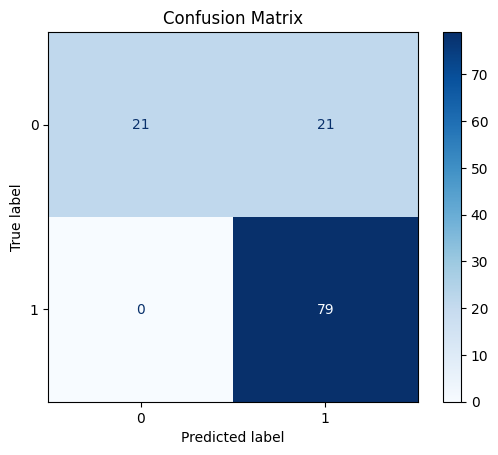

In [19]:
plot_confusion_matrix(y_test, y_pred_baseline)


In [20]:
def print_classification_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    """
    Prints classification metrics for binary classification.
    
    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels
    - y_proba: Predicted probabilities (optional, for ROC AUC)
    - model_name: Name of the model (for display)
    """
    print(f"\n📊 Classification Report for {model_name}:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, pos_label=0):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC AUC:   {roc_auc_score(y_true, y_proba):.4f}")


In [21]:
print_classification_metrics(y_test, y_pred_baseline, y_proba_baseline, model_name="Baseline Logistic Regression")


📊 Classification Report for Baseline Logistic Regression:
Accuracy:  0.8264
Precision: 0.7900
Recall:    0.5000
F1 Score:  0.8827
ROC AUC:   0.8945


### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [23]:
def train_random_forest_with_tuning(X_train, X_test, y_train):
    """
    Trains a Random Forest with hyperparameter tuning using RandomizedSearchCV.
    
    Parameters:
    - X_train: training features (DataFrame)
    - X_test: test features (DataFrame)
    - y_train: training labels (Series)

    Returns:
    - best_model: trained RandomForestClassifier with best parameters
    - y_pred: predicted class labels for X_test
    - y_proba: predicted class 1 probabilities for X_test
    """
    rf = RandomForestClassifier(random_state=42)

    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "class_weight": [None, "balanced"]
    }

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    return best_model, y_pred, y_proba, best_params

In [24]:
best_rf_model, y_pred_rf, y_proba_rf, best_param_rf = train_random_forest_with_tuning(X_train, X_test, y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [25]:
best_param_rf

{'class_weight': 'balanced',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

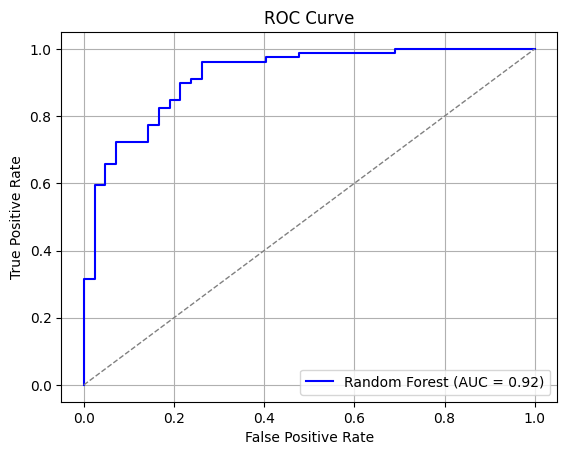

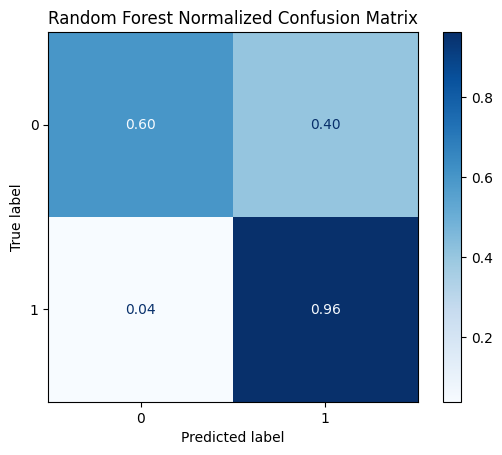

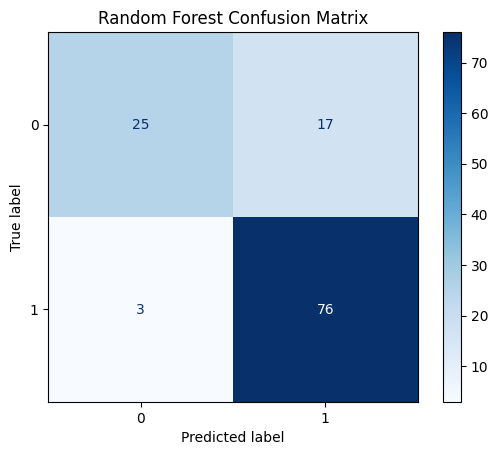


📊 Classification Report for Random Forest:
Accuracy:  0.8347
Precision: 0.8172
Recall:    0.5952
F1 Score:  0.8837
ROC AUC:   0.9183


In [26]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf, label="Random Forest")
plot_confusion_matrix(y_test, y_pred_rf, normalize="true", title="Random Forest Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, title = "Random Forest Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf, y_proba_rf, model_name="Random Forest")


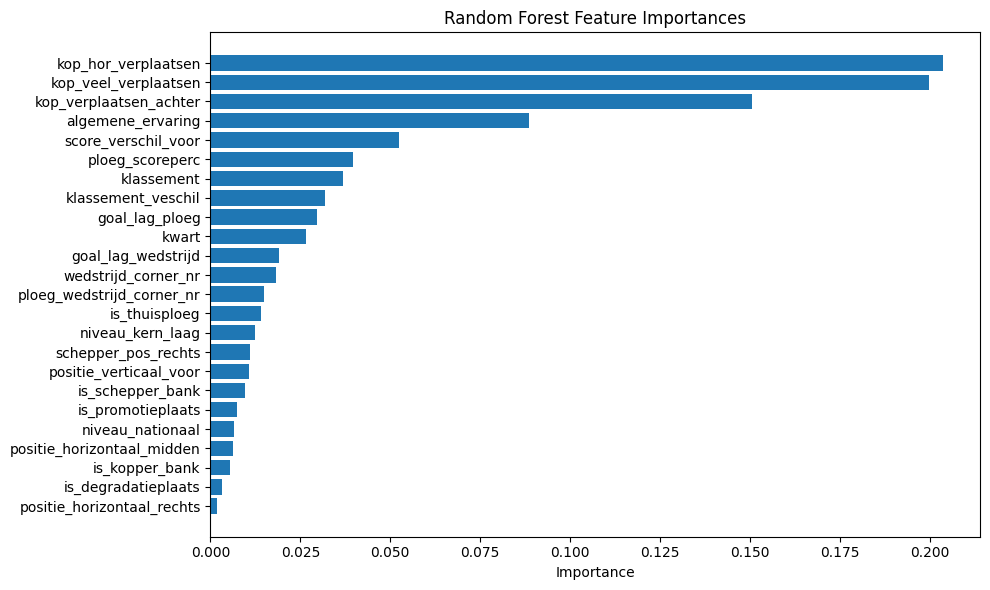

In [27]:
### Feature importances
# Extract importances
importances = best_rf_model.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Feature selection

In [28]:
### permutations for selecting right features
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

In [29]:
def cross_validated_permutation_importance(
    model_class, X, y, param_dict=None, scoring="roc_auc", n_splits=5, n_repeats=10, random_state=42, top_n=None
):
    """
    Compute and plot cross-validated permutation importances.

    Parameters:
    - model_class: sklearn model class (e.g., RandomForestClassifier)
    - X, y: pandas DataFrame and Series (features and target)
    - param_dict: dict of model hyperparameters
    - scoring: string, scoring metric for permutation importance (e.g., 'roc_auc')
    - n_splits: number of cross-validation folds
    - n_repeats: number of permutations per feature
    - random_state: random seed
    - top_n: number of top features to plot (optional)

    Returns:
    - DataFrame of average importances per feature
    """
    if param_dict is None:
        param_dict = {}

    importances_list = []
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        model = model_class(**param_dict, random_state=random_state)
        model.fit(X_train_cv, y_train_cv)

        result = permutation_importance(
            model, X_val_cv, y_val_cv,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )

        importances_list.append(result.importances_mean)

    mean_importances = np.mean(importances_list, axis=0)

    importance_df = pd.DataFrame({
        "feature": X.columns,
        "mean_importance": mean_importances
    }).sort_values(by="mean_importance", ascending=False)

    # Plot
    plot_df = importance_df.head(top_n) if top_n else importance_df
    plt.figure(figsize=(10, 6))
    plt.barh(plot_df["feature"], plot_df["mean_importance"])
    plt.gca().invert_yaxis()
    plt.title("Cross-Validated Permutation Feature Importances")
    plt.xlabel("Mean Decrease in ROC AUC")
    plt.tight_layout()
    plt.show()

    return importance_df

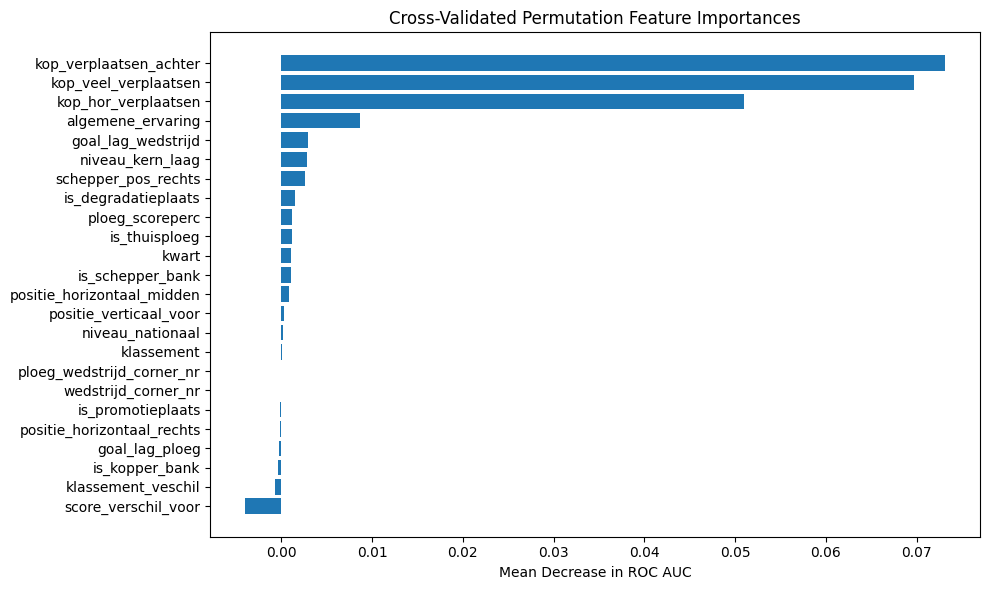

In [30]:
rf_permuted = cross_validated_permutation_importance(
    model_class=RandomForestClassifier,
    X=X_train,
    y=y_train,
    param_dict=best_param_rf,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
    
)


In [31]:
rf_permuted.head()

,feature,mean_importance
5,kop_verplaatsen_achter,0.073139
6,kop_veel_verplaatsen,0.069683
7,kop_hor_verplaatsen,0.050941
19,algemene_ervaring,0.008699
14,goal_lag_wedstrijd,0.002896


In [32]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_rf = rf_permuted[rf_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use = [item for item in rf_permuted["feature"].to_list() if item not in feat_to_remove_rf]

In [33]:
### rf without negative contribution of features
best_rf_model_pos_con, y_pred_rf_pos_con, y_proba_rf_pos_con, best_param_rf_pos_con = train_random_forest_with_tuning(X_train[cols_to_use], X_test[cols_to_use], y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


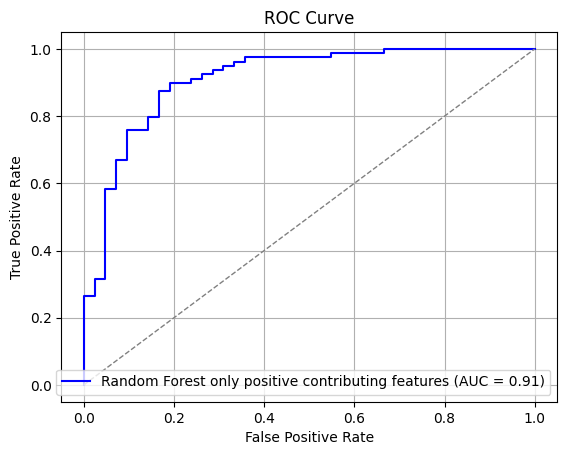

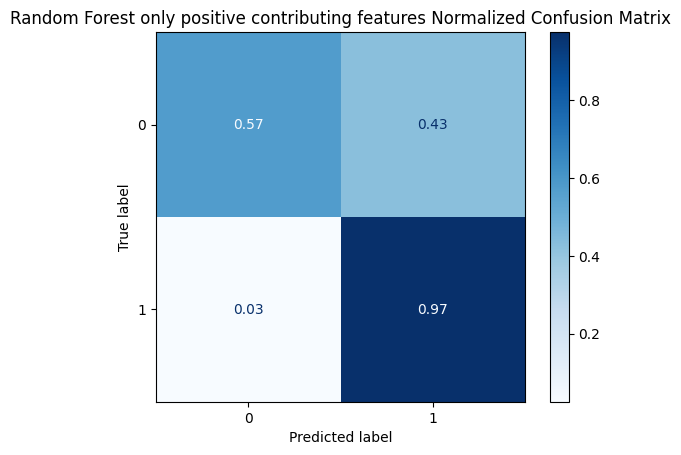

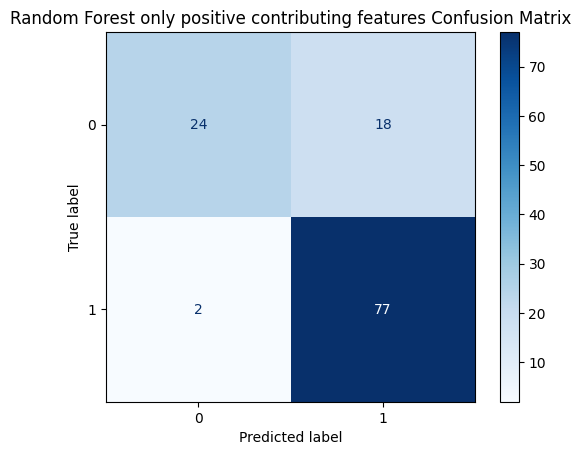


📊 Classification Report for Random Forest only positive contributing features:
Accuracy:  0.8347
Precision: 0.8105
Recall:    0.5714
F1 Score:  0.8851
ROC AUC:   0.9105


In [34]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_pos_con, label="Random Forest only positive contributing features")
plot_confusion_matrix(y_test, y_pred_rf_pos_con, normalize="true", title="Random Forest only positive contributing features Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_pos_con, title = "Random Forest only positive contributing features Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_pos_con, y_proba_rf_pos_con, model_name="Random Forest only positive contributing features")


### feature selection using Boruta

In [35]:
from boruta import BorutaPy

In [36]:
def select_features_with_boruta(estimator, X_train, y_train, random_state=42):
    """
    Voert feature selectie uit met BorutaPy en retourneert de geselecteerde feature namen.
    
    Parameters:
    - estimator: een sklearn-compatibel model (bijv. RandomForestClassifier)
    - X_train: pandas DataFrame met input features
    - y_train: pandas Series of array met doelvariabele
    - random_state: voor reproduceerbaarheid
    
    Returns:
    - selected_features: lijst van geselecteerde feature namen
    """
    boruta_selector = BorutaPy(estimator=estimator, n_estimators='auto', random_state=random_state)
    boruta_selector.fit(X_train.values, y_train.values)
    
    selected_features = X_train.columns[boruta_selector.support_].tolist()
    return selected_features

In [37]:
selected_features_boruta_rf = select_features_with_boruta(best_rf_model, X_train, y_train)

In [38]:
selected_features_boruta_rf

['kop_verplaatsen_achter',
 'kop_veel_verplaatsen',
 'kop_hor_verplaatsen',
 'score_verschil_voor',
 'algemene_ervaring']

In [39]:
best_rf_model_boruta, y_pred_rf_boruta, y_proba_rf_boruta, best_param_rf_boruta = train_random_forest_with_tuning(X_train[selected_features_boruta_rf], X_test[selected_features_boruta_rf], y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


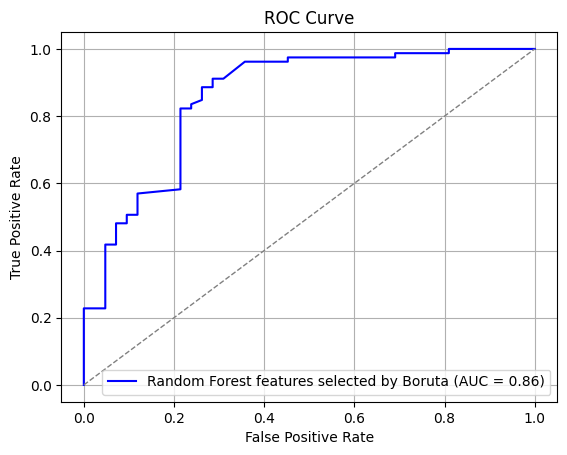

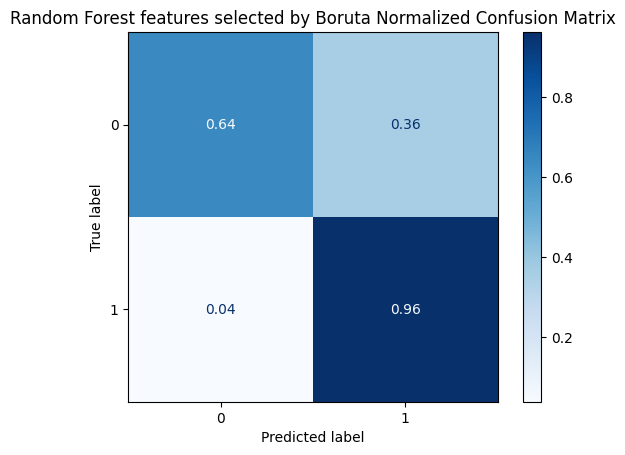

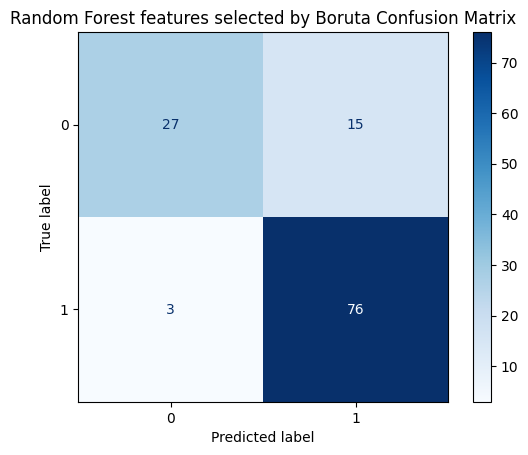


📊 Classification Report for Random Forest features selected by Boruta:
Accuracy:  0.8512
Precision: 0.8352
Recall:    0.6429
F1 Score:  0.8941
ROC AUC:   0.8579


In [40]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_boruta, label="Random Forest features selected by Boruta")
plot_confusion_matrix(y_test, y_pred_rf_boruta, normalize="true", title="Random Forest features selected by Boruta Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_boruta, title = "Random Forest features selected by Boruta Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_boruta, y_proba_rf_boruta, model_name="Random Forest features selected by Boruta")


### XGBoost

In [41]:
from xgboost import XGBClassifier

In [42]:


def train_xgb_with_tuning(X_train, X_test, y_train):
    """
    Trains an XGBoost model with hyperparameter tuning using RandomizedSearchCV.
    
    Parameters:
    - X_train: training features (DataFrame)
    - X_test: test features (DataFrame)
    - y_train: training labels (Series)

    Returns:
    - best_model: trained XGBClassifier with best parameters
    - y_pred: predicted class labels for X_test
    - y_proba: predicted class 1 probabilities for X_test
    - best_params: best hyperparameters
    """
    xgb = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )

    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.8, 1],
        "scale_pos_weight": [0.5, 1]  
        }

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    return best_model, y_pred, y_proba, best_params


In [43]:
best_xgb_model, y_pred_xgb, y_proba_xgb, best_param_xgb = train_xgb_with_tuning(X_train, X_test, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


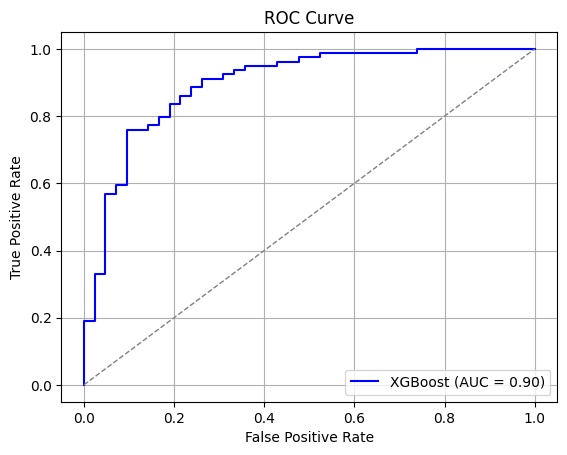

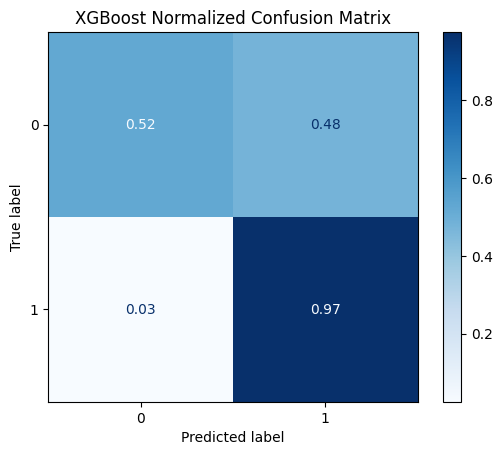

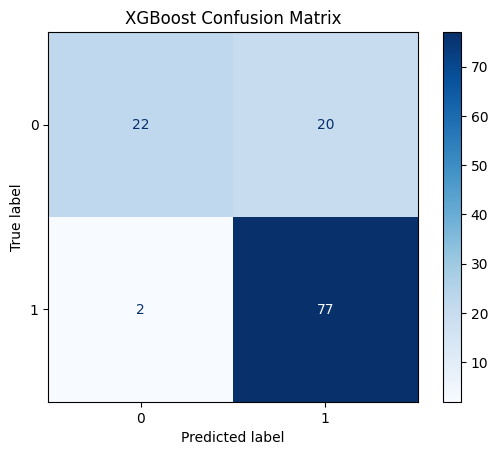


📊 Classification Report for XGBoost:
Accuracy:  0.8182
Precision: 0.7938
Recall:    0.5238
F1 Score:  0.8750
ROC AUC:   0.8963


In [44]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb, label="XGBoost")
plot_confusion_matrix(y_test, y_pred_xgb, normalize="true", title="XGBoost Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, title = "XGBoost Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb, y_proba_xgb, model_name="XGBoost")


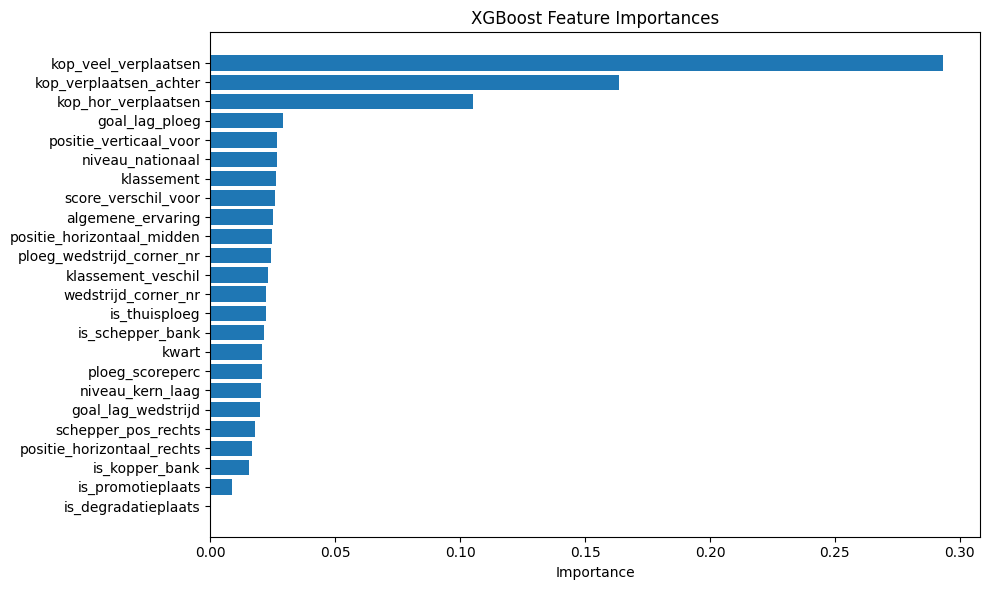

In [45]:
### Feature importances xgboost
# Extract importances
importances = best_xgb_model.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

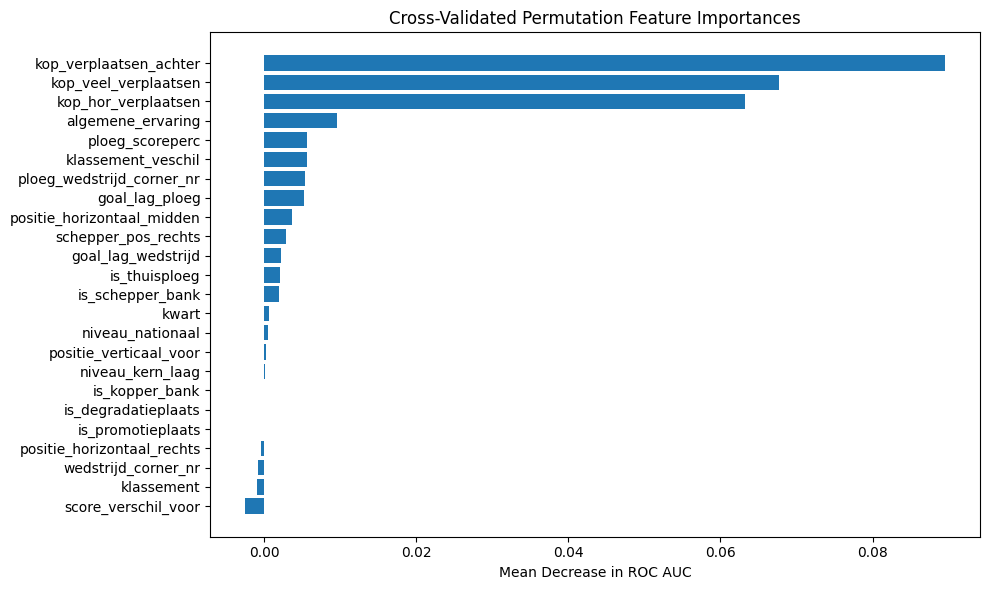

In [46]:
### permuting
xgb_permuted = cross_validated_permutation_importance(
    model_class=XGBClassifier,
    X=X_train,
    y=y_train,
    param_dict=best_param_xgb,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
)

In [47]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_xgb = xgb_permuted[xgb_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use_xgb = [item for item in xgb_permuted["feature"].to_list() if item not in feat_to_remove_xgb]

In [48]:
### xgb without negative contribution of features
best_xgb_model_pos_con, y_pred_xgb_pos_con, y_proba_xgb_pos_con, best_param_xgb_pos_con = train_random_forest_with_tuning(X_train[cols_to_use_xgb], X_test[cols_to_use_xgb], y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


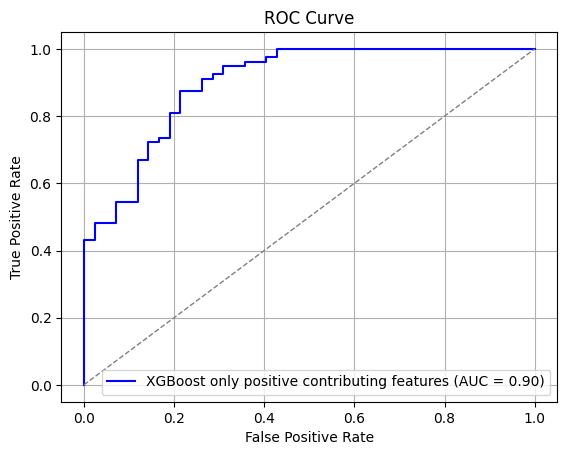

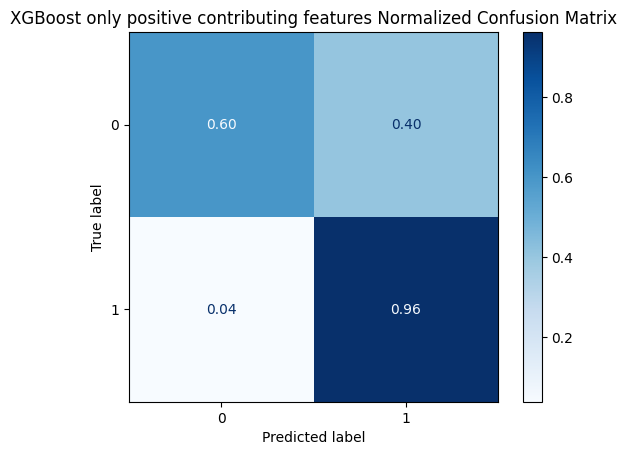

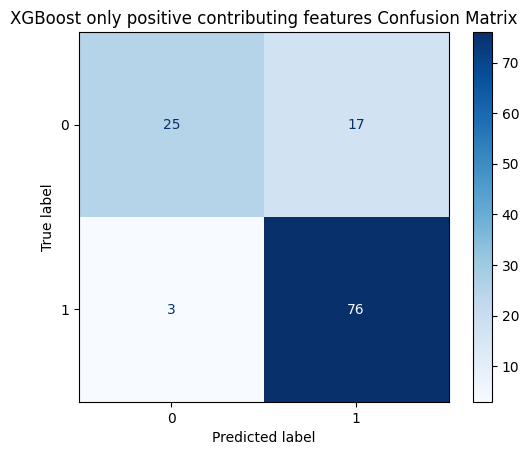


📊 Classification Report for XGBoost only positive contributing features:
Accuracy:  0.8347
Precision: 0.8172
Recall:    0.5952
F1 Score:  0.8837
ROC AUC:   0.8999


In [49]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_pos_con, label="XGBoost only positive contributing features")
plot_confusion_matrix(y_test, y_pred_xgb_pos_con, normalize="true", title="XGBoost only positive contributing features Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_pos_con, title = "XGBoost only positive contributing features Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_pos_con, y_proba_xgb_pos_con, model_name="XGBoost only positive contributing features")


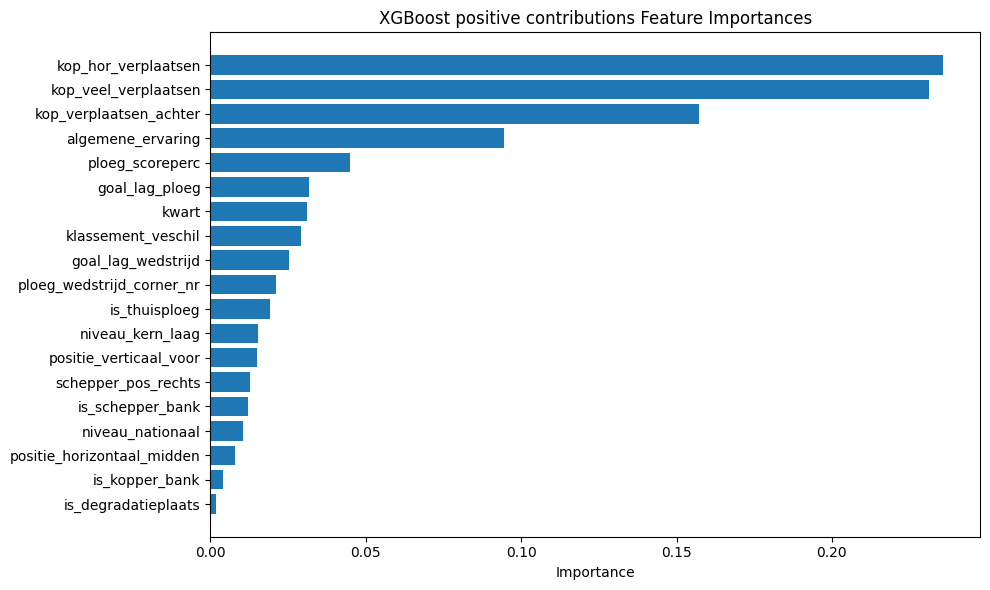

In [50]:
### feat importances improved model
# Ensure your feature importances and names match in length
# Extract importances
importances = best_xgb_model_pos_con.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train[cols_to_use_xgb].columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost positive contributions Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [51]:
### Boruta selection XGBoost
selected_features_boruta_xgb = select_features_with_boruta(best_xgb_model, X_train, y_train)

In [52]:
selected_features_boruta_xgb

['kop_verplaatsen_achter',
 'kop_veel_verplaatsen',
 'kop_hor_verplaatsen',
 'niveau_nationaal']

In [53]:
best_xgb_model_boruta, y_pred_xgb_boruta, y_proba_xgb_boruta, best_param_xgb_boruta = train_xgb_with_tuning(X_train[selected_features_boruta_xgb], X_test[selected_features_boruta_xgb], y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\cosyn\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


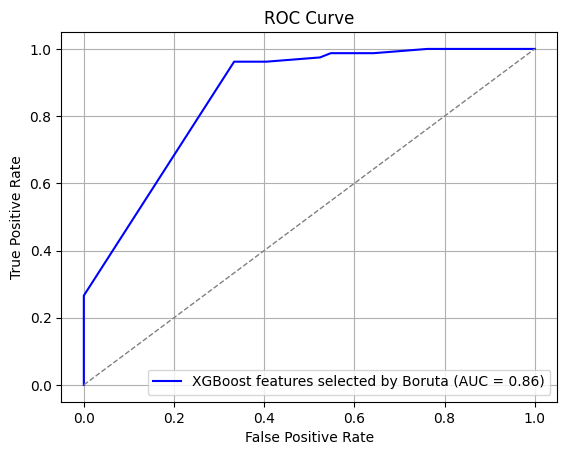

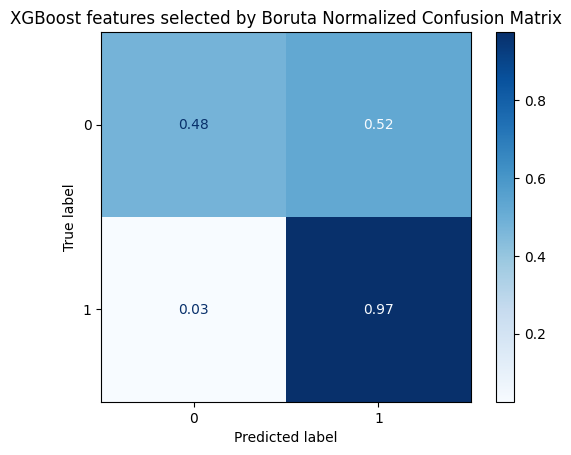

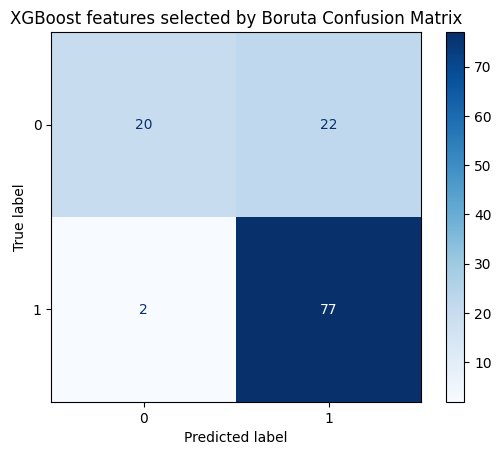


📊 Classification Report for XGBoost features selected by Boruta:
Accuracy:  0.8017
Precision: 0.7778
Recall:    0.4762
F1 Score:  0.8652
ROC AUC:   0.8624


In [54]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_boruta, label="XGBoost features selected by Boruta")
plot_confusion_matrix(y_test, y_pred_xgb_boruta, normalize="true", title="XGBoost features selected by Boruta Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_boruta, title = "XGBoost features selected by Boruta Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_boruta, y_proba_xgb_boruta, model_name="XGBoost features selected by Boruta")


### Comparison

In [55]:
def plot_multiple_roc_curves_from_scores(score_dict: dict, y_true, title="ROC Curves"):
    """
    Plot ROC curves from predicted probability scores (not models).

    Parameters:
    - score_dict: dict, keys are model names, values are predicted probabilities for the positive class
    - y_true: true labels
    - title: optional plot title
    """
    plt.figure(figsize=(8, 6))

    for name, y_scores in score_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


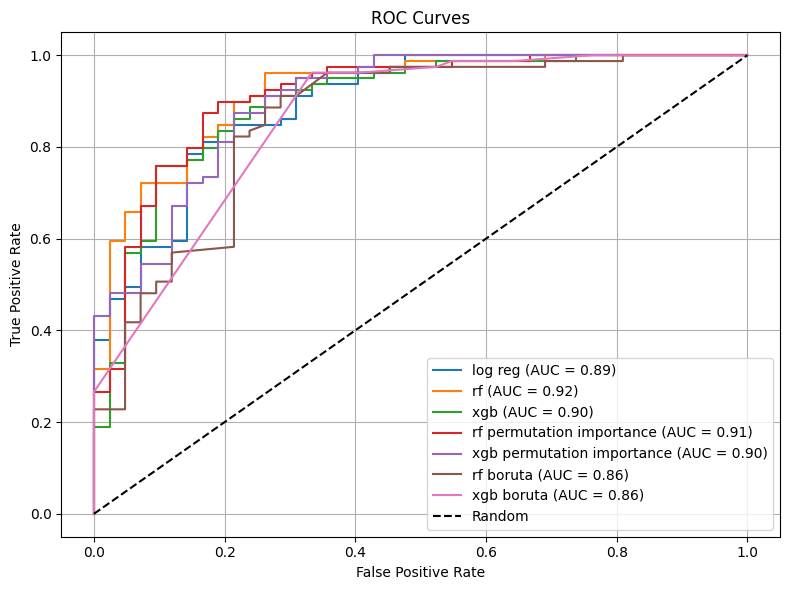

In [90]:
plot_multiple_roc_curves_from_scores({"log reg": y_proba_baseline, "rf": y_proba_rf, "xgb": y_proba_xgb, "rf permutation importance": y_proba_rf_pos_con, "xgb permutation importance": y_proba_xgb_pos_con, "rf boruta": y_proba_rf_boruta, "xgb boruta" : y_proba_xgb_boruta}, y_test, title="ROC Curves")

### model zonder schepkwaliteitindicatoren
wat kunnen ze doen, alleen info voor de schep geweten

In [57]:
X_train.columns

Index(['is_thuisploeg', 'kwart', 'is_schepper_bank', 'is_kopper_bank',
       'schepper_pos_rechts', 'kop_verplaatsen_achter', 'kop_veel_verplaatsen',
       'kop_hor_verplaatsen', 'score_verschil_voor', 'wedstrijd_corner_nr',
       'ploeg_wedstrijd_corner_nr', 'positie_verticaal_voor',
       'ploeg_scoreperc', 'goal_lag_ploeg', 'goal_lag_wedstrijd', 'klassement',
       'klassement_veschil', 'is_degradatieplaats', 'is_promotieplaats',
       'algemene_ervaring', 'positie_horizontaal_midden',
       'positie_horizontaal_rechts', 'niveau_kern_laag', 'niveau_nationaal'],
      dtype='object')

In [58]:
# 
X_train_voor = X_train.drop(columns=['kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen'])
X_test_voor = X_test.drop(columns=['kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen'])

### Baseline

In [59]:
# 2. baseline logistic regression (no tuning)
baseline_voor = LogisticRegression(max_iter=1000, random_state=42)

# 3. Fit model
baseline_voor.fit(X_train_voor, y_train)

# 4. Predict
y_pred_baseline_voor = baseline_voor.predict(X_test_voor)
y_proba_baseline_voor= baseline_voor.predict_proba(X_test_voor)[:,1]

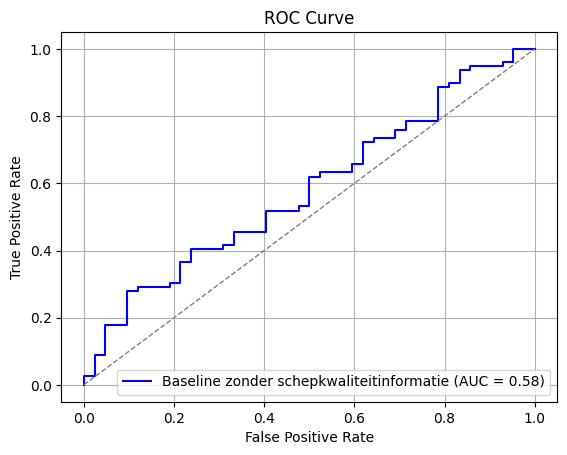

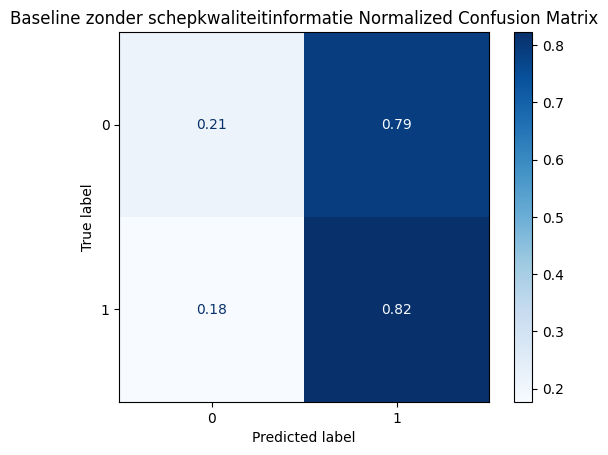

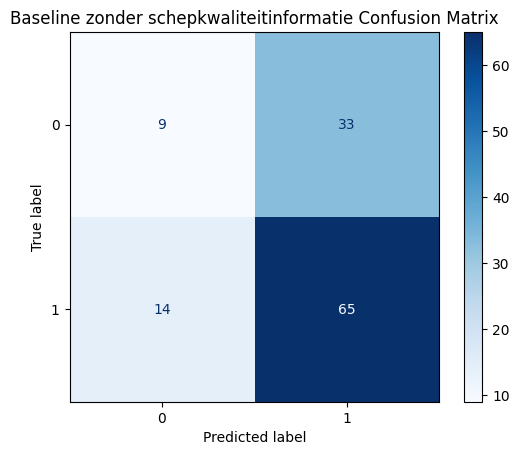


📊 Classification Report for Baseline zonder schepkwaliteitinformatie:
Accuracy:  0.6116
Precision: 0.6633
Recall:    0.2143
F1 Score:  0.7345
ROC AUC:   0.5808


In [60]:
# Evaluation
plot_roc_curve(y_test, y_proba_baseline_voor, label="Baseline zonder schepkwaliteitinformatie")
plot_confusion_matrix(y_test, y_pred_baseline_voor, normalize="true", title="Baseline zonder schepkwaliteitinformatie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_baseline_voor, title = "Baseline zonder schepkwaliteitinformatie Confusion Matrix")
print_classification_metrics(y_test, y_pred_baseline_voor, y_proba_baseline_voor, model_name="Baseline zonder schepkwaliteitinformatie")


In [105]:
# Voeg intercept toe
X_train_voor_const = sm.add_constant(X_train_voor)

# Fit logistische regressie
model = sm.Logit(y_train, X_train_voor_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.571875
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                  482
Model:                          Logit   Df Residuals:                      460
Method:                           MLE   Df Model:                           21
Date:                Wed, 28 May 2025   Pseudo R-squ.:                  0.1042
Time:                        20:18:58   Log-Likelihood:                -275.64
converged:                       True   LL-Null:                       -307.72
Covariance Type:            nonrobust   LLR p-value:                 2.955e-06
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.8524      0.723      2.561      0.010      

In [110]:
# Haal coëfficiënten en p-waarden op
coefs = model.params
p_values = model.pvalues

# Bereken odds ratio en procentuele verandering in odds
odds_ratios = np.exp(coefs)
percent_change = (odds_ratios - 1) * 100

# Bereken marginale effecten op kans (average marginal effects)
marginal_effects = model.get_margeff(at='mean', method='dydx')
marginal_df = marginal_effects.summary_frame()[['dy/dx']]
marginal_df.columns = ['marginal_effect_on_probability']
marginal_df['percent_point_change_in_probability'] = marginal_df['marginal_effect_on_probability'] * 100

# Combineer alle informatie
summary_df = pd.DataFrame({
    'coefficient': coefs,
    'p_value': p_values,
    'odds_ratio': odds_ratios,
    'percent_change_in_odds': percent_change
})

# Voeg marginale effecten toe aan de samenvatting
summary_df = summary_df.join(marginal_df)

# Filter voor p < 0.10, rond af op 3 decimalen en sorteer op p-waarde
summary_df_rounded = summary_df[summary_df.p_value <= 0.1].round(2).sort_values(by='p_value', ascending=True).drop(columns=['odds_ratio'])

# Toon de samengevoegde tabel
summary_df_rounded

,coefficient,p_value,percent_change_in_odds,marginal_effect_on_probability,percent_point_change_in_probability
algemene_ervaring,0.40,0.00,48.59,0.09,8.51
const,1.85,0.01,537.50,NaN,NaN
kwart,-0.35,0.01,-29.68,-0.08,-7.57
is_thuisploeg,-0.39,0.07,-32.04,-0.08,-8.30
goal_lag_ploeg,0.87,0.07,137.61,0.19,18.60
score_verschil_voor,0.20,0.08,21.95,0.04,4.27


### Random Forest

In [61]:
# aangezien er geen grote verschillen zijn tsn de modellen, ga ik zowel random forest en xgboost gebruiken
best_rf_voor, y_pred_rf_voor, y_proba_rf_voor, best_param_rf_voor = train_random_forest_with_tuning(X_train_voor, X_test_voor, y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


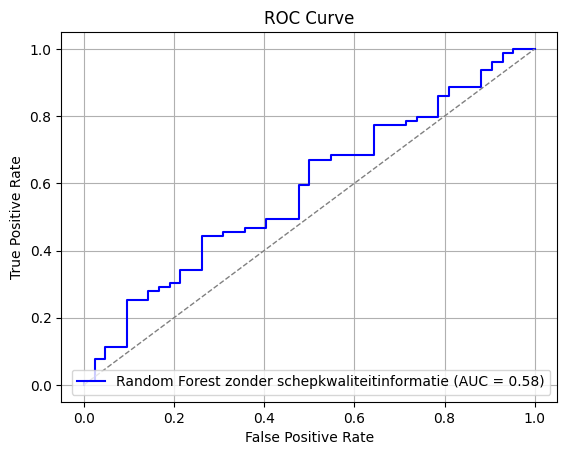

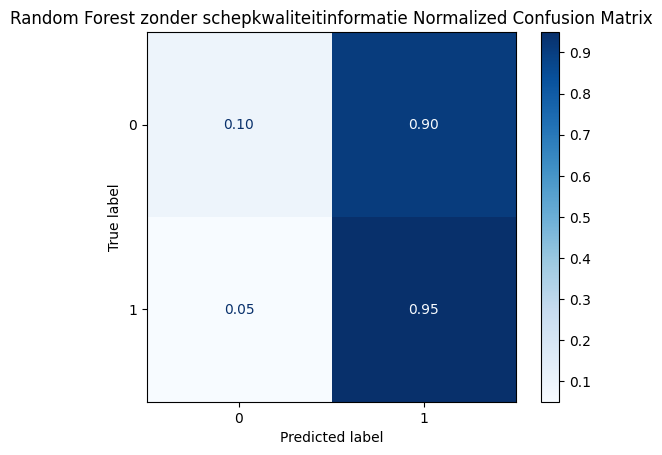

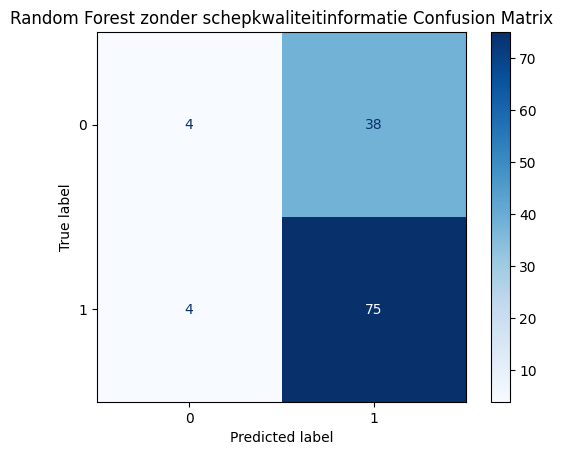


📊 Classification Report for Random Forest zonder schepkwaliteitinformatie:
Accuracy:  0.6529
Precision: 0.6637
Recall:    0.0952
F1 Score:  0.7812
ROC AUC:   0.5802


In [62]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_voor, label="Random Forest zonder schepkwaliteitinformatie")
plot_confusion_matrix(y_test, y_pred_rf_voor, normalize="true", title="Random Forest zonder schepkwaliteitinformatie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_voor, title = "Random Forest zonder schepkwaliteitinformatie Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_voor, y_proba_rf_voor, model_name="Random Forest zonder schepkwaliteitinformatie")


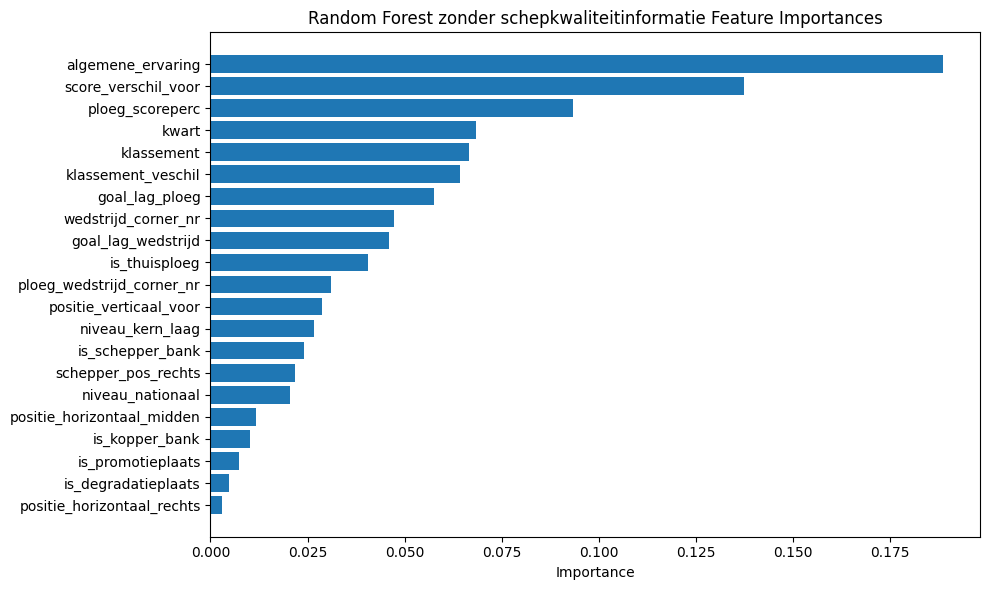

In [63]:
importances = best_rf_voor.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train_voor.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest zonder schepkwaliteitinformatie Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

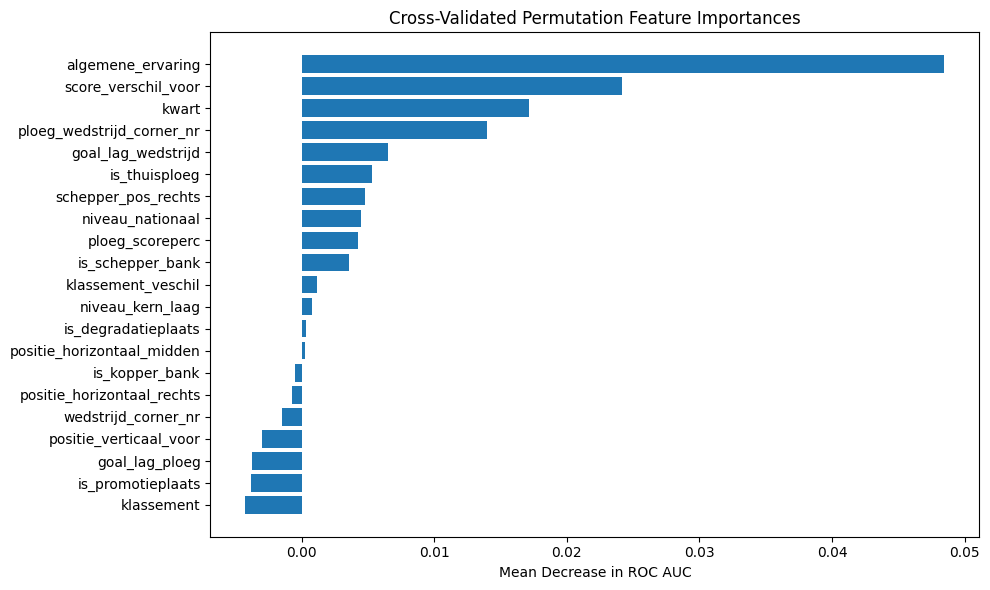

In [64]:
### permuting
rf_voor_permuted = cross_validated_permutation_importance(
    model_class=RandomForestClassifier,
    X=X_train_voor,
    y=y_train,
    param_dict=best_param_rf_voor,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
)

In [65]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_rf_voor = rf_voor_permuted[rf_voor_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use_rf_voor = [item for item in rf_voor_permuted["feature"].to_list() if item not in feat_to_remove_rf_voor]

In [66]:
best_rf_voor_pos_con, y_pred_rf_voor_pos_con, y_proba_rf_voor_pos_con, best_param_rf_voor_pos_con = train_random_forest_with_tuning(X_train_voor[cols_to_use_rf_voor], X_test_voor[cols_to_use_rf_voor], y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


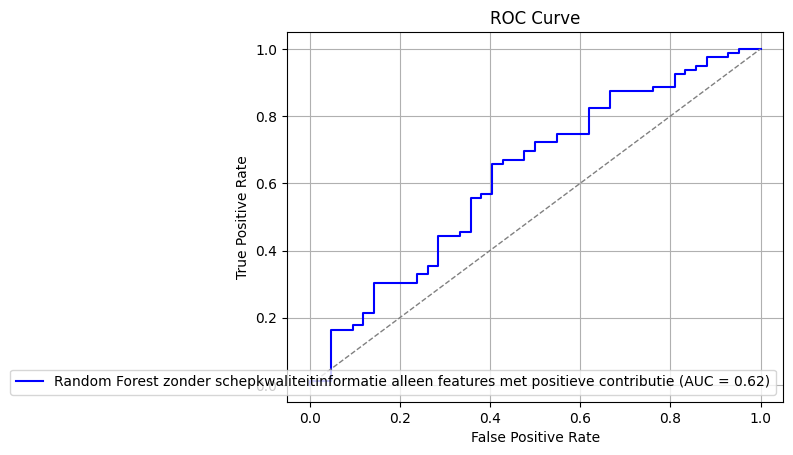

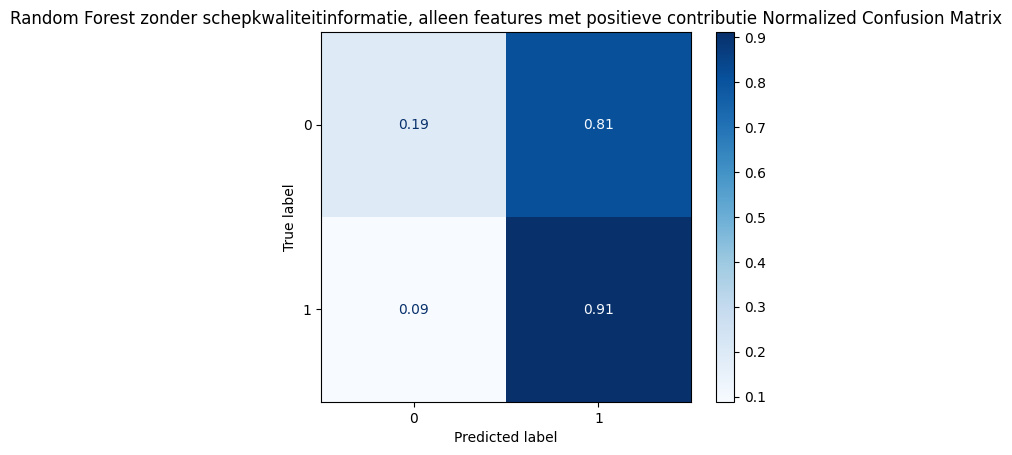

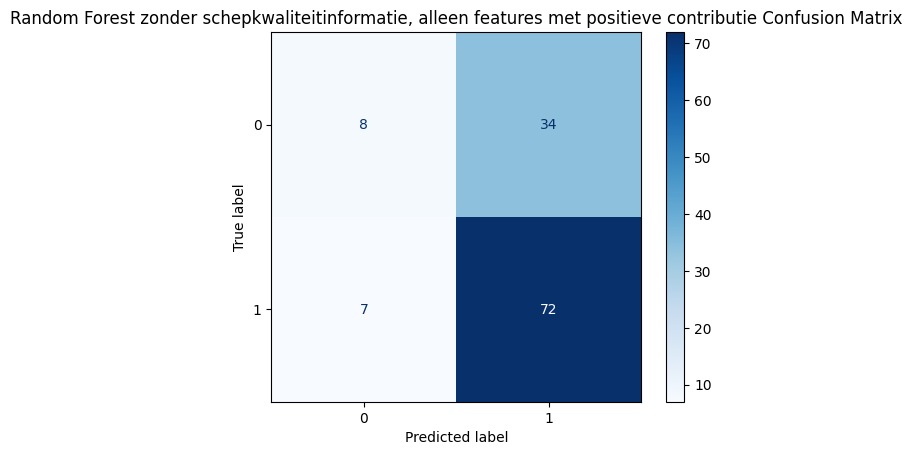


📊 Classification Report for Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie:
Accuracy:  0.6612
Precision: 0.6792
Recall:    0.1905
F1 Score:  0.7784
ROC AUC:   0.6227


In [67]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_voor_pos_con, label="Random Forest zonder schepkwaliteitinformatie alleen features met positieve contributie")
plot_confusion_matrix(y_test, y_pred_rf_voor_pos_con, normalize="true", title="Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_voor_pos_con, title = "Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_voor_pos_con, y_proba_rf_voor_pos_con, model_name="Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie")


In [68]:
### BORUTA voor rf zonder schepkwaliteitindicatoren
selected_features_boruta_rf_voor = select_features_with_boruta(best_rf_voor, X_train_voor, y_train)

In [69]:
selected_features_boruta_rf_voor

['algemene_ervaring']

In [70]:
best_rf_model_boruta_voor, y_pred_rf_boruta_voor, y_proba_rf_boruta_voor, best_param_rf_boruta_voor = train_random_forest_with_tuning(X_train_voor[selected_features_boruta_rf_voor], X_test_voor[selected_features_boruta_rf_voor], y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


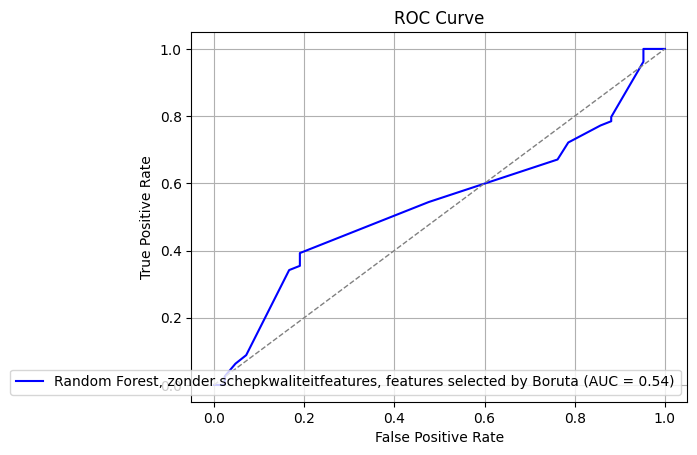

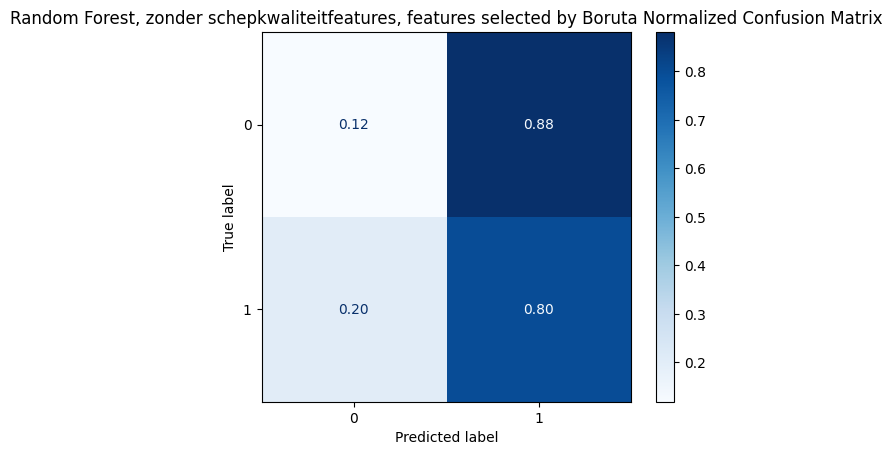

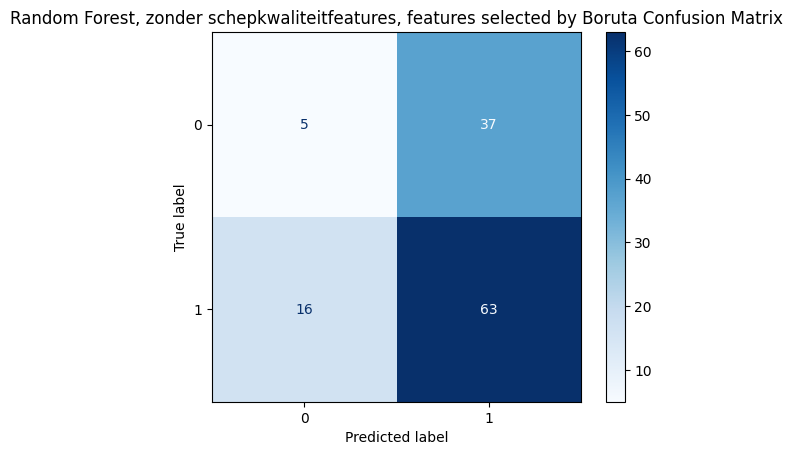


📊 Classification Report for Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta:
Accuracy:  0.5620
Precision: 0.6300
Recall:    0.1190
F1 Score:  0.7039
ROC AUC:   0.5380


In [71]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_boruta_voor, label="Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta")
plot_confusion_matrix(y_test, y_pred_rf_boruta_voor, normalize="true", title="Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_boruta_voor, title = "Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_boruta_voor, y_proba_rf_boruta_voor, model_name="Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta")


### XGBoost zonder schepkwaliteitindicatoren

In [72]:
best_xgb_voor, y_pred_xgb_voor, y_proba_xgb_voor, best_param_xgb_voor = train_xgb_with_tuning(X_train_voor, X_test_voor, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


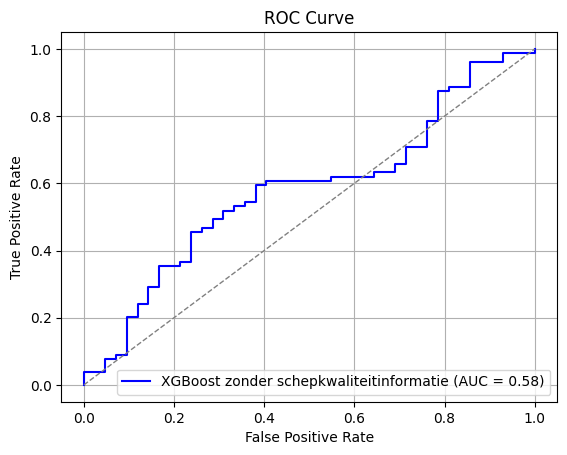

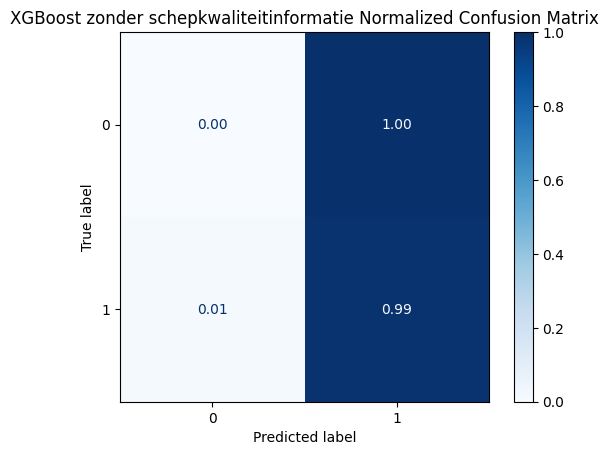

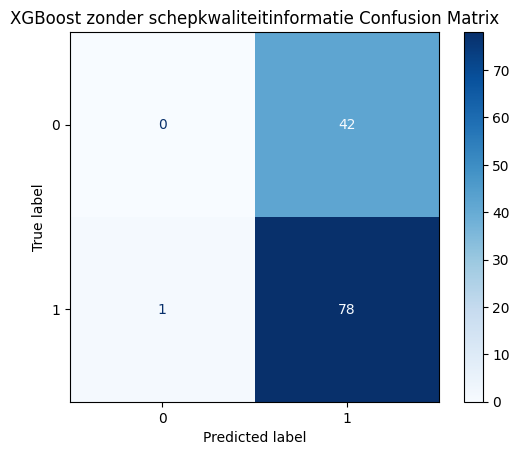


📊 Classification Report for XGBoost zonder schepkwaliteitinformatie:
Accuracy:  0.6446
Precision: 0.6500
Recall:    0.0000
F1 Score:  0.7839
ROC AUC:   0.5811


In [73]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_voor, label="XGBoost zonder schepkwaliteitinformatie")
plot_confusion_matrix(y_test, y_pred_xgb_voor, normalize="true", title="XGBoost zonder schepkwaliteitinformatie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_voor, title = "XGBoost zonder schepkwaliteitinformatie Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_voor, y_proba_xgb_voor, model_name="XGBoost zonder schepkwaliteitinformatie")


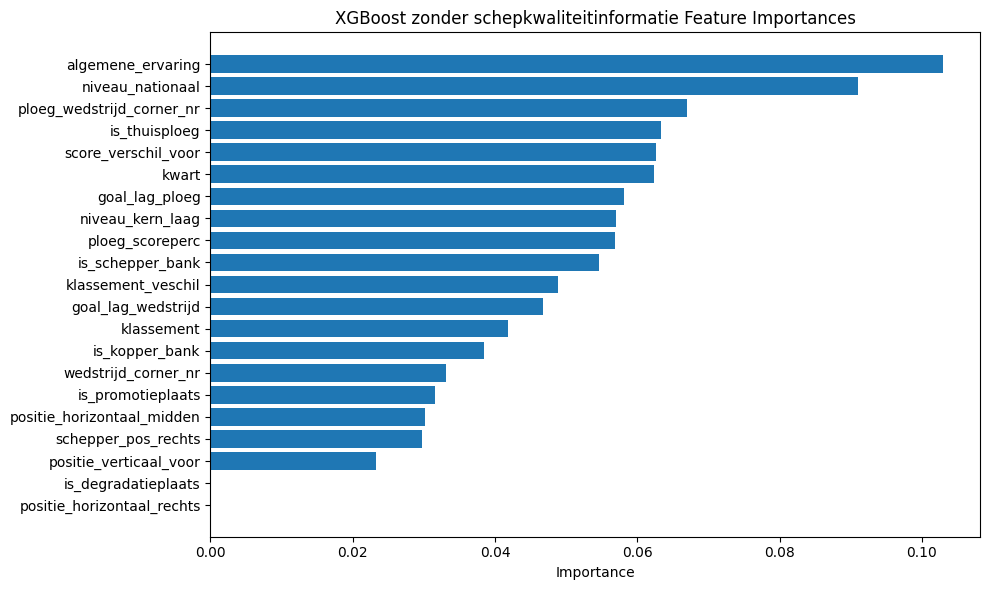

In [74]:
importances = best_xgb_voor.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train_voor.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost zonder schepkwaliteitinformatie Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

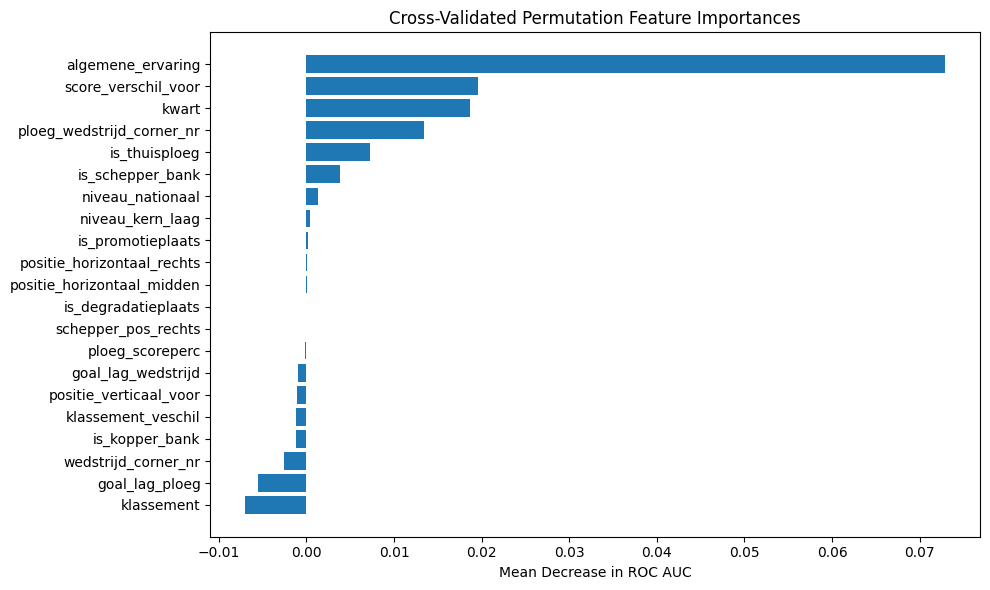

In [75]:
### permuting
xgb_voor_permuted = cross_validated_permutation_importance(
    model_class=XGBClassifier,
    X=X_train_voor,
    y=y_train,
    param_dict=best_param_xgb_voor,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
)

In [76]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_xgb_voor = xgb_voor_permuted[xgb_voor_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use_xgb_voor = [item for item in xgb_voor_permuted["feature"].to_list() if item not in feat_to_remove_xgb_voor]

In [77]:
best_xgb_voor_pos_con, y_pred_xgb_voor_pos_con, y_proba_xgb_voor_pos_con, best_param_xgb_voor_pos_con = train_random_forest_with_tuning(X_train_voor[cols_to_use_xgb_voor], X_test_voor[cols_to_use_xgb_voor], y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


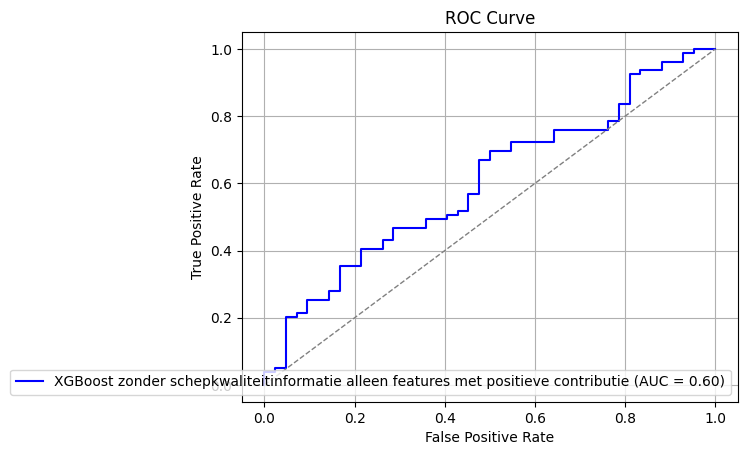

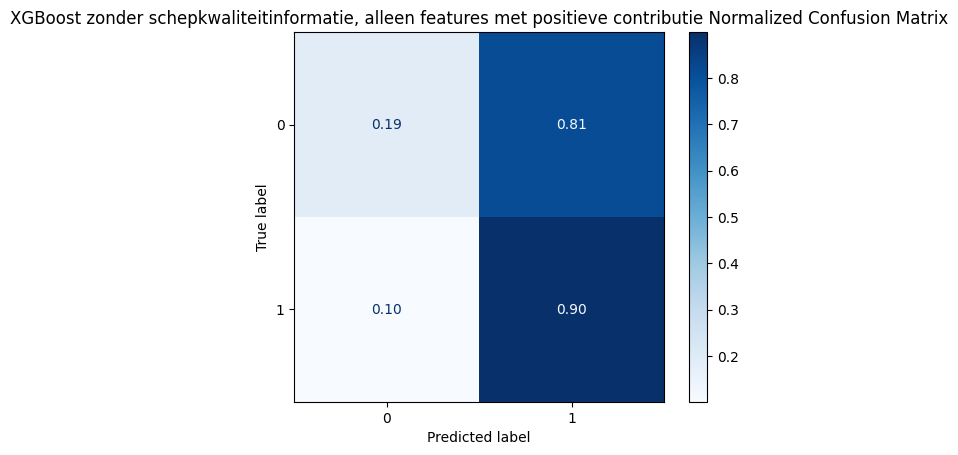

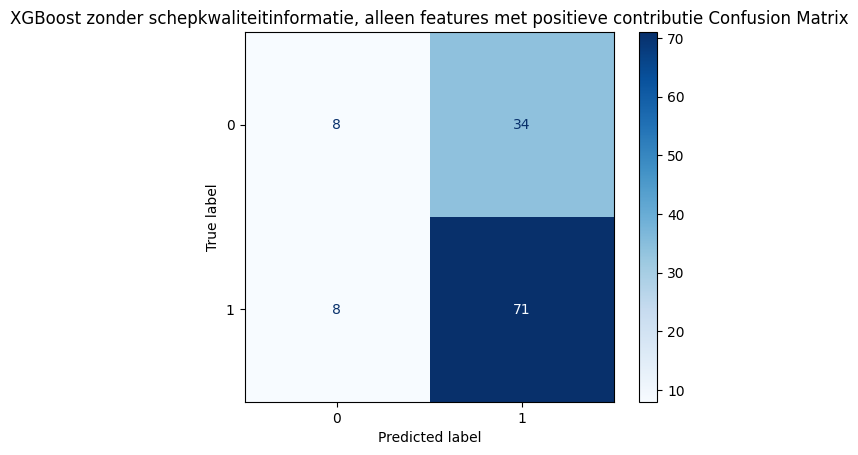


📊 Classification Report for XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie:
Accuracy:  0.6529
Precision: 0.6762
Recall:    0.1905
F1 Score:  0.7717
ROC AUC:   0.6025


In [78]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_voor_pos_con, label="XGBoost zonder schepkwaliteitinformatie alleen features met positieve contributie")
plot_confusion_matrix(y_test, y_pred_xgb_voor_pos_con, normalize="true", title="XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_voor_pos_con, title = "XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_voor_pos_con, y_proba_xgb_voor_pos_con, model_name="XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie")


In [79]:
### BORUTA XGBOOST zonder
selected_features_boruta_xgb_voor = select_features_with_boruta(best_rf_voor, X_train_voor, y_train)

In [80]:
selected_features_boruta_xgb_voor

['algemene_ervaring']

In [81]:
best_xgb_model_boruta_voor, y_pred_xgb_boruta_voor, y_proba_xgb_boruta_voor, best_param_xgb_boruta_voor = train_xgb_with_tuning(X_train_voor[selected_features_boruta_xgb_voor], X_test_voor[selected_features_boruta_xgb_voor], y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


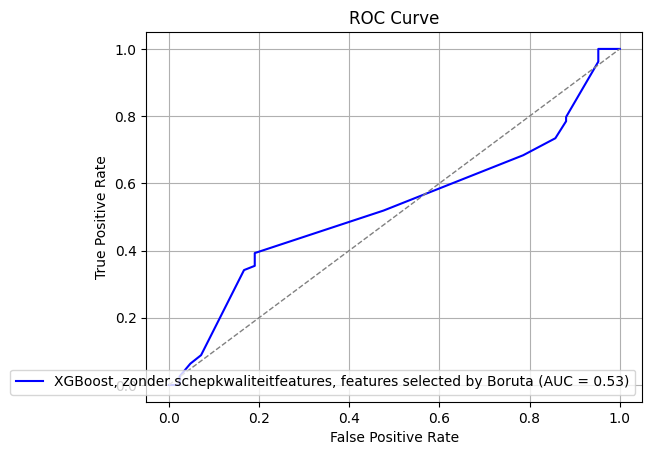

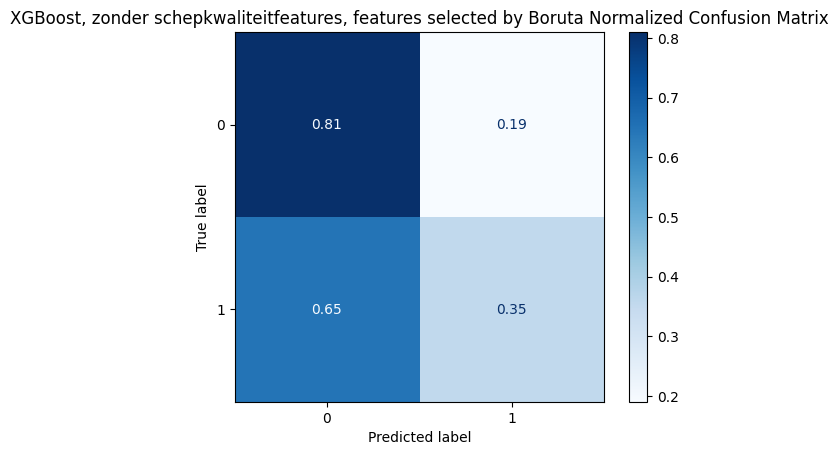

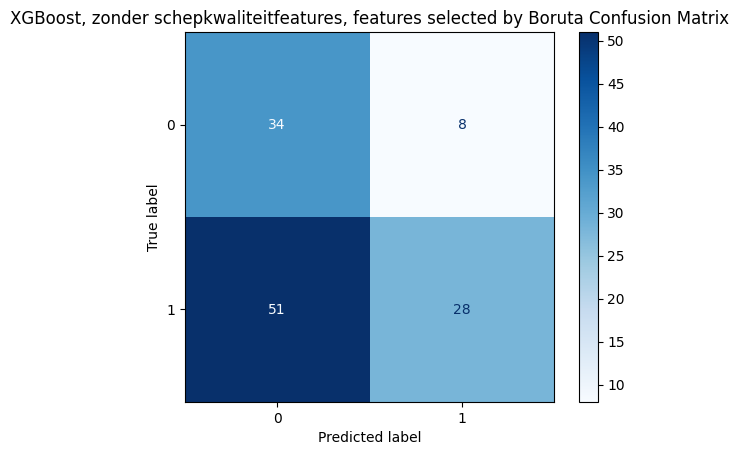


📊 Classification Report for Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta:
Accuracy:  0.5124
Precision: 0.7778
Recall:    0.8095
F1 Score:  0.4870
ROC AUC:   0.5271


In [82]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_boruta_voor, label="XGBoost, zonder schepkwaliteitfeatures, features selected by Boruta")
plot_confusion_matrix(y_test, y_pred_xgb_boruta_voor, normalize="true", title="XGBoost, zonder schepkwaliteitfeatures, features selected by Boruta Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_boruta_voor, title = "XGBoost, zonder schepkwaliteitfeatures, features selected by Boruta Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_boruta_voor, y_proba_xgb_boruta_voor, model_name="Random Forest, zonder schepkwaliteitfeatures, features selected by Boruta")


### Vergelijken performanties

In [83]:
from MLstatkit.stats import Delong_test

def compare_models_auc(y_true, y_proba_list, model_names, baseline_proba):
    """
    Vergelijk meerdere modellen met een baseline m.b.v. MLstatkit's DeLong test.

    Parameters:
        y_true (np.array): True binary labels
        y_proba_list (list of np.array): List of predicted probabilities from models
        model_names (list of str): List of model names (same order as y_proba_list)
        baseline_proba (np.array): Predicted probabilities from baseline model
    """
    baseline_auc = roc_auc_score(y_true, baseline_proba)
    print(f"Baseline AUC: {baseline_auc:.4f}\n" + "-"*40)

    for proba, name in zip(y_proba_list, model_names):
        model_auc = roc_auc_score(y_true, proba)
        z, p = Delong_test(y_true, baseline_proba, proba)

        print(f"{name}: AUC = {model_auc:.4f} | p-value vs. baseline = {p:.4f}")


In [84]:
compare_models_auc(y_test, [y_proba_rf, y_proba_rf_pos_con, y_proba_rf_boruta, y_proba_xgb, y_proba_xgb_pos_con, y_proba_xgb_boruta], ["RF", "RF pos con", "RF boruta","XGB", "XGB pos con", "XGB boruta"], y_proba_baseline)

Baseline AUC: 0.8945
----------------------------------------
RF: AUC = 0.9183 | p-value vs. baseline = 0.2197
RF pos con: AUC = 0.9105 | p-value vs. baseline = 0.5277
RF boruta: AUC = 0.8579 | p-value vs. baseline = 0.3604
XGB: AUC = 0.8963 | p-value vs. baseline = 0.9211
XGB pos con: AUC = 0.8999 | p-value vs. baseline = 0.7806
XGB boruta: AUC = 0.8624 | p-value vs. baseline = 0.2412


In [85]:
compare_models_auc(y_test, [y_proba_rf_voor, y_proba_rf_voor_pos_con, y_proba_rf_boruta_voor, y_proba_xgb_voor, y_proba_xgb_voor_pos_con, y_proba_rf_boruta_voor], ["RF zonder schepkwaliteit", "RF pos con zonder schepkwaliteit", "RF boruta zonder schepkwaliteit", "XGB zonder schepkwaliteit", "XGB pos con zonder schepkwaliteit", "RF boruta zonder schepkwaliteit"], y_proba_baseline_voor)

Baseline AUC: 0.5808
----------------------------------------
RF zonder schepkwaliteit: AUC = 0.5802 | p-value vs. baseline = 0.9857
RF pos con zonder schepkwaliteit: AUC = 0.6227 | p-value vs. baseline = 0.2509
RF boruta zonder schepkwaliteit: AUC = 0.5380 | p-value vs. baseline = 0.4524
XGB zonder schepkwaliteit: AUC = 0.5811 | p-value vs. baseline = 0.9918
XGB pos con zonder schepkwaliteit: AUC = 0.6025 | p-value vs. baseline = 0.5407
RF boruta zonder schepkwaliteit: AUC = 0.5380 | p-value vs. baseline = 0.4524


In [86]:
# vergelijking van selectie methodes, eerst permutatie
compare_models_auc(y_test, [y_proba_rf_pos_con], ["RF pos con"], y_proba_rf)
compare_models_auc(y_test, [y_proba_xgb_pos_con], ["RF pos con"], y_proba_xgb)
compare_models_auc(y_test, [y_proba_rf_voor_pos_con], ["RF pos con zonder schepkwaliteit"], y_proba_rf_voor)
compare_models_auc(y_test, [y_proba_xgb_voor_pos_con], ["RF pos con zonder schepkwaliteit"], y_proba_xgb_voor)


Baseline AUC: 0.9183
----------------------------------------
RF pos con: AUC = 0.9105 | p-value vs. baseline = 0.6501
Baseline AUC: 0.8963
----------------------------------------
RF pos con: AUC = 0.8999 | p-value vs. baseline = 0.8436
Baseline AUC: 0.5802
----------------------------------------
RF pos con zonder schepkwaliteit: AUC = 0.6227 | p-value vs. baseline = 0.0797
Baseline AUC: 0.5811
----------------------------------------
RF pos con zonder schepkwaliteit: AUC = 0.6025 | p-value vs. baseline = 0.3614


In [87]:
# vergelijking van selectie methodes, nu boruta
compare_models_auc(y_test, [y_proba_rf_boruta], ["RF boruta"], y_proba_rf)
compare_models_auc(y_test, [y_proba_xgb_boruta], ["RF boruta"], y_proba_xgb)
compare_models_auc(y_test, [y_proba_rf_boruta_voor], ["RF boruta zonder schepkwaliteit"], y_proba_rf_voor)
compare_models_auc(y_test, [y_proba_xgb_boruta_voor], ["RF boruta zonder schepkwaliteit"], y_proba_xgb_voor)


Baseline AUC: 0.9183
----------------------------------------
RF boruta: AUC = 0.8579 | p-value vs. baseline = 0.0954
Baseline AUC: 0.8963
----------------------------------------
RF boruta: AUC = 0.8624 | p-value vs. baseline = 0.1973
Baseline AUC: 0.5802
----------------------------------------
RF boruta zonder schepkwaliteit: AUC = 0.5380 | p-value vs. baseline = 0.4425
Baseline AUC: 0.5811
----------------------------------------
RF boruta zonder schepkwaliteit: AUC = 0.5271 | p-value vs. baseline = 0.2247


In [88]:
# Vergelijking van de modellen met en zonder schepkwaliteitinformatie
compare_models_auc(y_test, [y_proba_baseline_voor], ["Baseline"], y_proba_baseline)
compare_models_auc(y_test, [y_proba_rf_voor], ["RF"], y_proba_rf)
compare_models_auc(y_test, [y_proba_xgb_voor], ["XGB"], y_proba_xgb)


Baseline AUC: 0.8945
----------------------------------------
Baseline: AUC = 0.5808 | p-value vs. baseline = 0.0000
Baseline AUC: 0.9183
----------------------------------------
RF: AUC = 0.5802 | p-value vs. baseline = 0.0000
Baseline AUC: 0.8963
----------------------------------------
XGB: AUC = 0.5811 | p-value vs. baseline = 0.0000
